In [1]:
# import some require library
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

### Custom Image Dataset

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, include_feature_vector=True):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_list = self._generate_image_list()
        self.include_feature_vector = include_feature_vector

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]

        # Use PIL to open the image
        image = Image.open(img_path).convert('RGB')

        subcategory_name = os.path.basename(os.path.dirname(img_path))  # Get subcategory name
        label = subcategory_name  # The category name is the label

        if self.transform:
            image = self.transform(image)

        feature_vector = np.array([[1, 1, 1]])
        if self.include_feature_vector:
            # Load the pre-computed vector from the corresponding .npy file
            vector_name = f'{os.path.splitext(os.path.basename(img_path))[0]}_vector.npy'
            vector_path = os.path.join(os.path.dirname(img_path), vector_name)
            feature_vector = np.load(vector_path)

        return label, image, feature_vector

    def _generate_image_list(self):
        image_list = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for root, _, files in os.walk(class_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_list.append(os.path.join(root, file))
        return image_list

# Define the transform for images (you can customize this based on your requirements)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),           # Convert to tensor
])

# Define the dataset
image_directory = 'Images/'  # Replace with the actual directory path
custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=False)

# Define the DataLoader
batch_size = 32
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

# Get labels over batches
all_labels = []

# Iterate through the DataLoader
for labels, images, _ in data_loader:
    # Process your data or perform training/validation steps here
    print("Image Shape:", images.shape)
    # Get labels
    all_labels.extend(labels)

# Print the unique labels
unique_labels = set(all_labels)
print("Unique Labels:", unique_labels)

Image Shape: torch.Size([20, 3, 224, 224])
Unique Labels: {'Regular Fit Shirt', 'Men Shirt', 'Linen Regular Fit Shirt', 'Men Checked Shirt'}


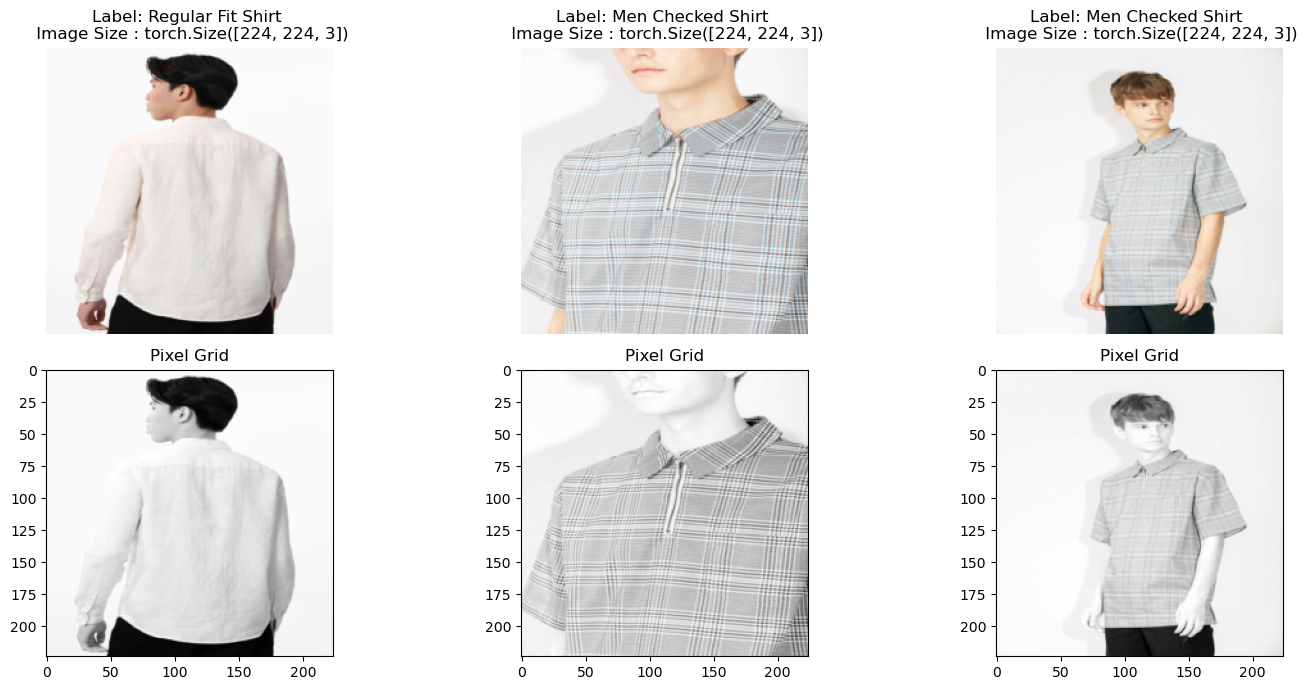

In [3]:
# Now let's plot some random images
def show_images_with_grid(images, labels, num_images=3):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 7))

    for i in range(num_images):
        image = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
        label = labels[i]

        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Label: {label} \n Image Size : {image.size()}")
        axes[0, i].axis('off')

        # Display pixel grid
        axes[1, i].imshow(images[i][0], cmap='gray')  # Assuming images are in grayscale
        axes[1, i].set_title("Pixel Grid")
        axes[1, i].axis('on')

    plt.tight_layout()
    plt.show()

# Get a batch from the DataLoader
for labels, images,_ in data_loader:
    # Show the first 5 images along with their labels and pixel grids
    show_images_with_grid(images, labels, num_images=3)
    break  # Break after showing the first batch


### Load Pretrained Model

In [4]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# Image transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

D:\Mamba\mambaforge\envs\capstone2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Mamba\mambaforge\envs\capstone2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Convert image to vector

In [5]:
# Define function to convert image to vector
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
      my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)

    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding.numpy()

### Apply get_vector function to each images

In [6]:
# Initialize an empty list to store feature vectors and corresponding image paths
all_feature_vectors = []
all_image_paths = []

# Iterate through the DataLoader
for labels, _, _ in data_loader:
    # Accumulate image paths
    all_image_paths.extend(custom_dataset.image_list[:len(labels)])

# Apply get_vector to each image in the batch
batch_feature_vectors = [get_vector(image_path) for image_path in all_image_paths]

# Save the feature vectors in the same directory with .npy extension
for i, feature_vector in enumerate(batch_feature_vectors):
    image_path = all_image_paths[i]
    save_path = os.path.splitext(image_path)[0] + '_vector.npy'
    np.save(save_path, feature_vector)
    print(f'Saved: {save_path}')


Saved: Images/shirt\Men Checked Shirt\Ten1-Men-Short-Sleeves-Checked-Shirt (1)_vector.npy
Saved: Images/shirt\Men Checked Shirt\Ten1-Men-Short-Sleeves-Checked-Shirt (2)_vector.npy
Saved: Images/shirt\Men Checked Shirt\Ten1-Men-Short-Sleeves-Checked-Shirt (3)_vector.npy
Saved: Images/shirt\Men Checked Shirt\Ten1-Men-Short-Sleeves-Checked-Shirt (4)_vector.npy
Saved: Images/shirt\Men Checked Shirt\Ten1-Men-Short-Sleeves-Checked-Shirt (5)_vector.npy
Saved: Images/shirt\Men Checked Shirt\Ten1-Men-Short-Sleeves-Checked-Shirt (6)_vector.npy
Saved: Images/shirt\Men Checked Shirt\Ten1-Men-Short-Sleeves-Checked-Shirt (7)_vector.npy
Saved: Images/shirt\Men Shirt\Men-Shirt (4)_vector.npy
Saved: Images/shirt\Men Shirt\Men-Shirt (5)_vector.npy
Saved: Images/shirt\Men Shirt\Men-Shirt (6)_vector.npy
Saved: Images/t-shirt\Linen Regular Fit Shirt\Regular-Fit-Shirt (1)_vector.npy
Saved: Images/t-shirt\Linen Regular Fit Shirt\Regular-Fit-Shirt (2)_vector.npy
Saved: Images/t-shirt\Linen Regular Fit Shirt\R

In [7]:
# Define the dataset
image_directory = 'Images/'  # Replace with the actual directory path
custom_dataset = CustomImageDataset(root_dir=image_directory, transform=image_transform, include_feature_vector=True)

# Define the DataLoader
batch_size = 32
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)
unique_labels = set()

# Iterate through the DataLoader
for labels, images, feature_vector in data_loader:
    # Process your data or perform training/validation steps here
    unique_labels.update(labels)
    print("Image Shape:", images.shape)
    print("Feature Vector Shape:", feature_vector.shape)

# Print the unique labels
print("Unique Labels:", unique_labels)

dataset_size = len(custom_dataset)
print(f'Total number of images in the dataset: {dataset_size}')

Image Shape: torch.Size([20, 3, 224, 224])
Feature Vector Shape: torch.Size([20, 512])
Unique Labels: {'Regular Fit Shirt', 'Men Shirt', 'Linen Regular Fit Shirt', 'Men Checked Shirt'}
Total number of images in the dataset: 20


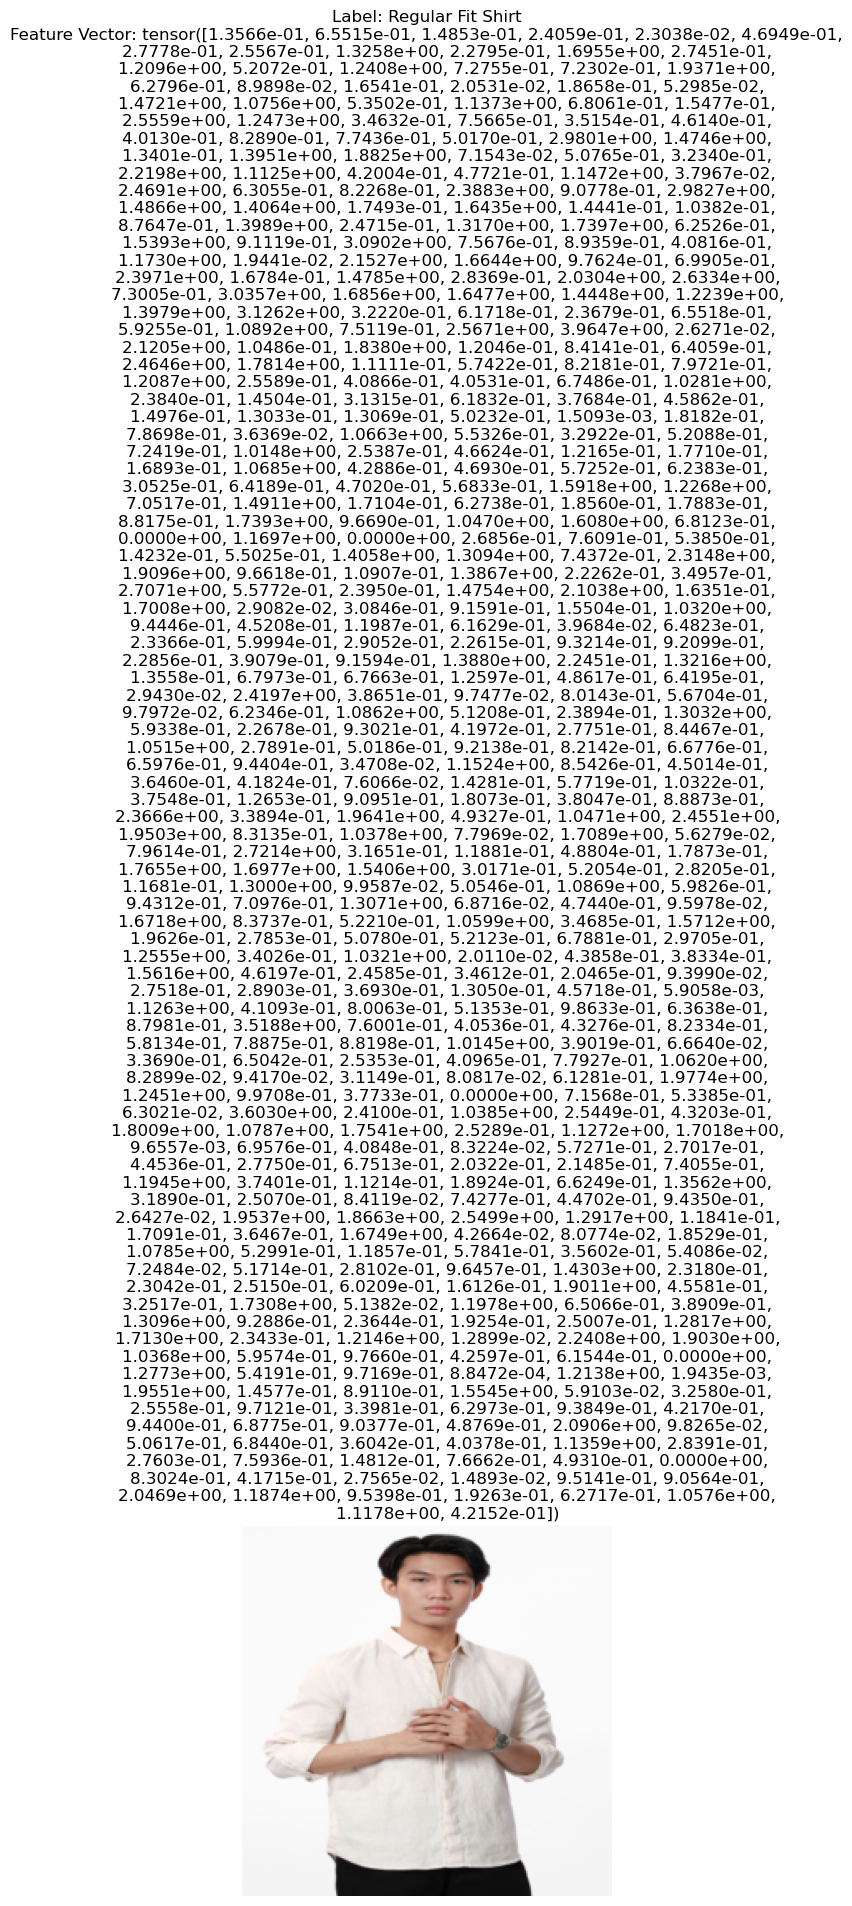

In [8]:
# Let's display a single image with label and feature vector
def show_image_with_info(image, label, feature_vector):
    plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for displaying with matplotlib
    plt.title(f"Label: {label}\nFeature Vector: {feature_vector}")
    plt.axis('off')
    plt.show()

# Get a batch from the DataLoader (assuming batch size is 1)
for labels, images, feature_vectors in data_loader:
    # Show the first image along with its label and feature vector
    show_image_with_info(images[0], labels[0], feature_vectors[0])
    break  # Break after showing the first batch